These are the codes we used to train a model for diagnosing cherry blossom leaves by  images.

First of all, import modules that are needed to train a model.

In [ ]:
import torch
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import (TensorDataset, DataLoader, Dataset)
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from google.colab import drive
from torch import optim, nn

mount google drive in order to use images uploaded in google drive.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


load train and validation images and process them in order to do fine-tuning using Resnet18.

In [ ]:
train_imgs = ImageFolder('/content/drive/My Drive/Cherry_leaves_3/train',
    transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.ToTensor()]
))

val_imgs = ImageFolder('/content/drive/My Drive/Cherry_leaves_3/val',
    transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()]
))

train_loader = DataLoader(
    train_imgs, batch_size=128, shuffle=True
)
val_loader = DataLoader(
    val_imgs, batch_size=128, shuffle=False
)

load Resnet18　and replace the last linear layer.

In [ ]:
net = models.resnet18(pretrained=True)

fc_input_dim = net.fc.in_features 
net.fc = nn.Linear(fc_input_dim, 2)

for p in net.parameters():
    p.requires_grad=True

learning_curv_y_val = []
learning_curv_y_train = []
learning_curv_x = [i for i in range(21)]

In [ ]:
params_to_update_1 = []
params_to_update_2 = []

for name, param in net.named_parameters():
    if 'layer' in name:
        param.requires_grad = True
        params_to_update_1.append(param)

    elif 'fc' in name:
        param.requires_grad = True
        params_to_update_2.append(param)

    else:
        param.requires_grad = False

The function to evaluate model at each epoch.

In [ ]:
def eval_net(net, data_loader, device="cpu"):
    # not to use batchnorm or dropout
    net.eval()
    ys = []
    ypreds = []

    for x, y in data_loader:
        # transfer x and y to device(GPU)
        x = x.to(device)
        y = y.to(device)
        # predict the most likely class
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)

    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # compute the accuracy
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()


the function to train model.

In [ ]:
def train_net(net, train_loader, val_loader,
              loss_fn=nn.CrossEntropyLoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    
    optimizer = optim.SGD([
            {'params' : params_to_update_1, 'lr' : 1e-4},
            {'params' : params_to_update_2, 'lr' : 1e-3}
    ], momentum=0.9)

    for epoch in range(n_iter):
            
        running_loss = 0.0
        # change mode to train
        net.train()
        n = 0
        n_acc = 0
        
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
                total=len(train_loader)):
                xx = xx.to(device)
                yy = yy.to(device)
                h = net(xx)
                loss = loss_fn(h, yy)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                n += len(xx)
                _, y_pred = h.max(1)
                n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
            # the accuracy of training data
        train_acc.append(n_acc / n)
        learning_curv_y_train.append(n_acc / n)
            # the accuracy of validation data
        val_acc.append(eval_net(net, val_loader, device))
        learning_curv_y_val.append(eval_net(net, val_loader, device))

        print(epoch, train_losses[-1], train_acc[-1],
                val_acc[-1], flush=True)

let the model learn parameters.

In [ ]:

net.to("cuda:0")
learning_curv_y_train.append(eval_net(net, train_loader, device="cuda:0"))
learning_curv_y_val.append(eval_net(net, val_loader, device="cuda:0"))

train_net(net, train_loader, val_loader, n_iter=20 , device="cuda:0")

100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


0 0.8316504433751106 0.5383944153577661 0.7305555939674377


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


1 0.4008915312588215 0.9013961605584643 0.9555555582046509


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


2 0.18547843303531408 0.9860383944153578 0.9888889193534851


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


3 0.10776846669614315 0.9956369982547993 0.9833333492279053


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


4 0.0757155274040997 0.9956369982547993 0.9833333492279053


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


5 0.05824954528361559 0.9982547993019197 0.9888889193534851


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


6 0.04976553423330188 0.9991273996509599 0.9861111640930176


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


7 0.04438991588540375 0.9973821989528796 0.9861111640930176


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


8 0.03952366206794977 0.9982547993019197 0.9861111640930176


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


9 0.03957276581786573 1.0 0.9861111640930176


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


10 0.034385356586426497 1.0 0.9916666746139526


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


11 0.030683240620419383 0.9991273996509599 0.9972222447395325


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


12 0.02890267362818122 1.0 0.9944444894790649


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


13 0.02775506698526442 0.9982547993019197 0.9944444894790649


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


14 0.02534755296073854 0.9982547993019197 0.9972222447395325


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


15 0.02577867277432233 0.9982547993019197 0.9972222447395325


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


16 0.024225842207670212 0.9982547993019197 0.9972222447395325


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


17 0.02027202525641769 1.0 0.9972222447395325


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


18 0.02010192780289799 1.0 0.9972222447395325


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


19 0.022448784788139164 0.9991273996509599 0.9972222447395325


compute the accuracy by test images.

In [ ]:
test_imgs = ImageFolder('/content/drive/My Drive/Cherry_leaves_3/test',
    transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()]
))

test_loader = DataLoader(
    test_imgs, batch_size=128, shuffle=True
)

In [ ]:
print(eval_net(net, test_loader, device="cuda:0"))

0.9975000023841858


save the model.

In [ ]:
path = "/content/drive/My Drive/iGEM/Cherry_model_Fine_Tuning.pth"
torch.save(net.state_dict(), path)

plot learning curves.

Text(0.5, 1.0, 'learning curve')

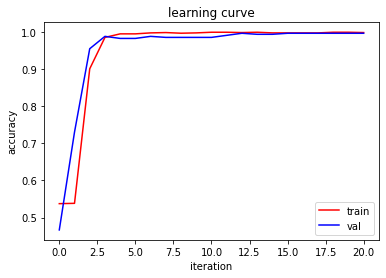

In [ ]:
plt.plot(learning_curv_x, learning_curv_y_train, label = "train", color = "red")

plt.plot(learning_curv_x, learning_curv_y_val, label = "val", color = "blue")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.title("learning curve")